Step 1: Calculate different technical indexes

Also create indicators function, that applies all technical indicator functions to a dataframe.

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf

#On Balance Volume
def obv(df):
    def dobv(now,previous,volume):
        return np.sign(now-previous)*volume

    df['previous_open'] = df['open'].shift(1)  # Shift to get the previous price
    df['dobv'] = df.apply(lambda row: dobv(row['open'], row['previous_open'], row['volume']), axis=1)

    df['obv'] = df['dobv'].cumsum()
    df = df.drop(columns = ['dobv','previous_open'])
    return df

#Aroon oscillator
def aroon(df, window=25):
    # Get how many periods ago the highest high occurred + calculate Aroon Up
    df['AU'] = df['high'].rolling(window).apply(lambda x: float(window - x[::-1].argmax()) / window * 100, raw=True)

    # Get how many periods ago the lowest low occurred + calculate Aroon Down
    df['AD'] = df['low'].rolling(window).apply(lambda x: float(window - x[::-1].argmin()) / window * 100, raw=True)

    df['aroon'] = df['AU'] - df['AD']

    df = df.drop(columns = ['AD','AU'])
    return df

#Stochastic oscillator
def SO(df, window=25):
    
    # Getting highest high and lowest low in the last n=window days
    df['lowest_low'] = df['low'].rolling(window=window).min()
    df['highest_high'] = df['high'].rolling(window=window).max()

    # Actual formula for stochastic oscillator 
    df['SO'] = 100 * ((df['close'] - df['lowest_low']) / (df['highest_high'] - df['lowest_low']))

    #Lowest low and highest high aren't necessary anymore
    df = df.drop(columns = ['lowest_low','highest_high'])
    
    return df

#Moving average
def moving_average(df):
    df['avg200'] = df['close'].rolling(window=200).mean()
    df['avg50'] = df['close'].rolling(window=50).mean()
    df['avg25'] = df['close'].rolling(window=25).mean()
    df['avg20'] = df['close'].rolling(window=20).mean()
    df['avg14'] = df['close'].rolling(window=14).mean()
    return df

#ADX
def ADX(df, n=14):
    # True Range (TR)
    df['tr'] = np.maximum(df['high'] - df['low'], 
                          np.maximum(abs(df['high'] - df['close'].shift(1)), 
                                     abs(df['low'] - df['close'].shift(1))))
    
    # Positive and Negative Directional Movement
    df['dm+'] = np.where((df['high'] - df['high'].shift(1) > df['low'] - df['low'].shift(1)) & 
                         (df['high'] - df['high'].shift(1) > 0), df['high'] - df['high'].shift(1), 0)
    
    df['dm-'] = np.where((df['low'] - df['low'].shift(1) > df['high'] - df['high'].shift(1)) & 
                         (df['low'] - df['low'].shift(1) > 0), df['low'] - df['low'].shift(1), 0)
    
    # Smooth the TR, dm+, and dm- using exponential moving average (EMA)
    df['tr_ema'] = df['tr'].rolling(window=n).mean()
    df['dm+_ema'] = df['dm+'].rolling(window=n).mean()
    df['dm-_ema'] = df['dm-'].rolling(window=n).mean()
    
    # Calculate the Directional Indexes (DI+ and DI-)
    df['di+'] = 100 * (df['dm+_ema'] / df['tr_ema'])
    df['di-'] = 100 * (df['dm-_ema'] / df['tr_ema'])
    
    # Calculate the Directional Movement Index (DX)
    df['dx'] = 100 * (abs(df['di+'] - df['di-']) / (df['di+'] + df['di-']))
    
    # ADX calculation (smoothed DX)
    df['adx'] = df['dx'].rolling(window=n).mean()

    df = df.drop(columns = ['tr','dm+','dm-','tr_ema','dm+_ema','dm-_ema','di+','di-','dx'])
    return df#ADX

#Relative strength Indicator
def RSI(df, n=14):
    # Calculate the price changes between periods (delta)
    df['delta'] = df['close'].diff(1)
    
    # Calculate gain and loss
    df['gain'] = np.where(df['delta'] > 0, df['delta'], 0)
    df['loss'] = np.where(df['delta'] < 0, abs(df['delta']), 0)
    
    # Calculate the initial average gain and loss over the first n periods
    df['avg_gain'] = df['gain'].rolling(window=n, min_periods=n).mean().shift(1)
    df['avg_loss'] = df['loss'].rolling(window=n, min_periods=n).mean().shift(1)
    
    # Calculate the smoothed average gain and loss using previous values
    df['avg_gain'] = df['avg_gain'].ewm(com=n-1, adjust=False).mean()
    df['avg_loss'] = df['avg_loss'].ewm(com=n-1, adjust=False).mean()
    
    # Compute the Relative Strength (RS)
    df['rs'] = df['avg_gain'] / df['avg_loss']
    
    # Compute the RSI
    df['rsi'] = 100 - (100 / (1 + df['rs']))
    
    # Return the RSI values

    df = df.drop(columns = ['gain','loss','avg_gain','avg_loss','rs'])
    return df

#Bollinger Bands
def bollinger(df):
    df = moving_average(df)

    df['SD'] = df['close'].rolling(window=20).std()
    
    # Calculate the Upper and Lower Bollinger Bands
    df['upper band'] = df['avg20'] + (2 * df['SD'])
    df['lower band'] = df['avg20'] - (2 * df['SD'])

    return df
    
# Function that gets a given dataframe and applies all the functions listed above to it, allowing the user to choose among various technical indicators.
def indicators(df):
    #Apply all functions
    df = obv(df)
    df = aroon(df)
    df = SO(df)
    df = moving_average(df)
    df = ADX(df)
    df = RSI(df)
    df = bollinger(df)

    return df

Step 2: Implement strategies based on indexes as functions that can be applied to the dataframe.
All strategies return 0 or 1 as a buy or sell signal.
The apply function applies each of these strategies in indicators(df) of a given stock. A dataframe with the yield over time is returned. There is also the possibility to short stocks in the apply function, but this feature is set to false.

Essentially, the only thing that changes in each of these strategies can be found in #Check for bullish/bearish conditions. The rest of the code is identical.

In [4]:
def strat_moving_average(df):
    trends = [0]

    # Initialize the market state to 'bearish'
    market_state = 0
    
    # List to store the trend status for each row, starting with 'bearish' for the first row
    trends = [0]

    # Iterate over the DataFrame starting from the second row (index 1)
    for i in range(1, len(df)):
        # Check for bullish conditions
        if df['avg50'].iloc[i] > df['avg200'].iloc[i]:
            # Change the market state to 'bullish' if previously 'bearish'
            market_state = 1
        
        # Check for bearish conditions
        elif df['avg50'].iloc[i] < df['avg200'].iloc[i]:
            # Change the market state to 'bearish' if previously 'bullish'
            market_state = 0
        
        # Append the current market state to the trends list
        trends.append(market_state)
    
    # Return the trends list
    df['trend'] = trends
    return df

def strat_rsi_SO(df):
    trends = [0]

    # Initialize the market state to 'bearish'
    market_state = 1
    
    # List to store the trend status for each row, starting with 'bearish' for the first row
    trends = [0]

    # Iterate over the DataFrame starting from the second row (index 1)
    for i in range(1, len(df)):
        # Check for bullish conditions
        if df['rsi'].iloc[i] < 30:
            # Change the market state to 'bullish' if previously 'bearish'
            market_state = 1
        
        # Check for bearish conditions
        elif df['rsi'].iloc[i] > 70:
            # Change the market state to 'bearish' if previously 'bullish'
            market_state = 0
        
        # Append the current market state to the trends list
        trends.append(market_state)
    
    # Return the trends list
    df['trend'] = trends
    return df

def strat_bollinger(df):
    trends = [0]

    # Initialize the market state to 'bearish'
    market_state = 1
    
    # List to store the trend status for each row, starting with 'bearish' for the first row
    trends = [0]

    # Iterate over the DataFrame starting from the second row (index 1)
    for i in range(1, len(df)):
        # Check for bullish conditions
        if df['close'].iloc[i] > df['upper band'].iloc[i]:
            # Change the market state to 'bullish' if previously 'bearish'
            market_state = 1
        
        # Check for bearish conditions
        elif df['close'].iloc[i] < df['lower band'].iloc[i]:
            # Change the market state to 'bearish' if previously 'bullish'
            market_state = 0
        
        # Append the current market state to the trends list
        trends.append(market_state)
    
    # Return the trends list
    df['trend'] = trends
    return df

def apply(ticker, strat, short=False):
    # Fetch historical data for the specified ticker
    msft = yf.Ticker(ticker)
    df = msft.history(period="2y", interval="1d")

    # Clean up the DataFrame by dropping unnecessary columns and renaming others
    df = df.drop(columns=['Dividends', 'Stock Splits'], errors = 'ignore')
    df.rename(columns={
        'Date': 'date',
        'Open': 'open',
        'High': 'high',
        'Low': 'low',
        'Close': 'close',
        'Volume': 'volume'
    }, inplace=True)

    # Apply indicators and strategy
    df = strat(indicators(df))

    # Calculate returns based on the market position (long or short)
    if not short:
        df['returns'] = (df['close'] - df['close'].shift(1)) * (df['trend'])

    else:
        df['returns'] = (df['close'] - df['close'].shift(1)) * (2*df['trend'] -1)
        
    # Calculate cumulative returns
    df['total_returns'] = df['returns'].cumsum()

    return df

The graph below shows what happens if you applied the boilinger bands strategy in the Nvidia stock from 2022 to 2024.
The straght lines in the graph represents the moment the stock was sold, implying there is no market movement.

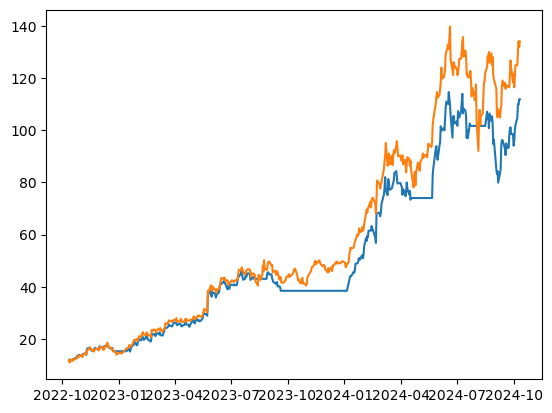

In [6]:
plt.plot(apply('nvda',strat_bollinger)['total_returns'] + apply('nvda',strat_rsi_SO)['open'].iloc[0])
plt.plot(apply('nvda',strat_rsi_SO)['open'])

In [7]:
tickers = ['aapl','nvda','msft','amzn','meta','googl','avgo','lly','tsla','jpm']

The get_returns function receives a list of tickers and gives a ratio between the returns of your strategy and the return of the stock in a given time period when applying a given trading strategy. Notice how it is possible to set shorting as true or false here too!

In [9]:
def get_returns(tickers, strat, short=False):
    delta_returns = []
    
    for ticker in tickers:
        df = apply(ticker, strat, short)
        # Calculate the percentage return based on initial and final price
        delta_return = df['total_returns'].iloc[-1] / (df['close'].iloc[-1] - df['close'].iloc[0])
        delta_returns.append(delta_return)
    
    return delta_returns

get_returns(tickers, strat_bollinger,False)

[1.09154567268193,
 0.8135650427794368,
 1.0406448200719534,
 0.7265544613815695,
 0.8822539355609699,
 1.166067620048896,
 0.801309467657939,
 0.7133108836141191,
 244.1082288828338,
 0.9284428891885066]

The main function applies de get_returns function to many different strategies simultaneously. The function returns a dataframe that associates each strategy to a ticker. Each cell represents the alpha of each strategy applied to each ticker, allowing the user to evaluate which strategy performed the best in which stock.

In [11]:
def main(tickers, strats, short=True):
    # Initialize an empty DataFrame to store the results, with strategies as index and tickers as columns
    results = pd.DataFrame(index=[strat.__name__ for strat in strats], columns=tickers)
    
    for strat in strats:
        # Get the returns for all tickers using the current strategy
        returns = get_returns(tickers, strat, short)
        # Store the returns in the corresponding row (strategy) and columns (tickers)
        results.loc[strat.__name__] = returns
    
    return results

In [12]:
strats = [strat_moving_average, strat_rsi_SO, strat_bollinger]
main(tickers, strats, False)

,aapl,nvda,msft,amzn,meta,googl,avgo,lly,tsla,jpm
strat_moving_average,-0.100779,0.714197,0.417604,0.745653,0.573527,0.47007,0.665933,0.779009,-144.911362,0.565707
strat_rsi_SO,0.568155,0.01618,0.789442,1.0,0.055189,0.378305,0.027067,0.060138,113.232616,0.170296
strat_bollinger,1.091546,0.813565,1.040645,0.726554,0.882254,1.166068,0.801309,0.713311,244.108229,0.928443


By far, the best performing strategy among the ones evaluated is the one that consists on applying bollinger bands.
However, even this strategy performed worse than the market in 60% of the stocks studied, as indicated by the ratios smaller than 1.

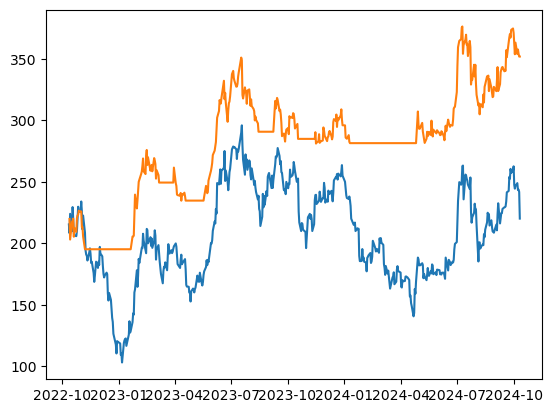

In [39]:
plt.plot(apply('tsla',strat_bollinger)['open'])
plt.plot(apply('tsla',strat_bollinger)['total_returns'] + apply('tsla',strat_bollinger)['open'].iloc[0])